In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# 1. 設定裝置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# 2. 資料前處理與載入
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)), # VGG16 需要 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
# 1. 載入預訓練的 VGG16 模型
model = models.vgg16(pretrained=True)

# 2. 凍結 VGG16 的特徵提取層參數 (不更新權重)
for param in model.parameters():
    param.requires_grad = False


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 96.0MB/s]


In [16]:
# 3. 替換最後的分類層 (VGG16 的最後一層是 'classifier[6]')
# 原本是 1000 類，我們改成 2 類 (貓 vs 狗)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2) # 2 代表貓和狗

# 將模型移至 GPU
model = model.to(device)

In [18]:
# 1. 定義資料轉換 (Transforms)
# VGG16 預設輸入是 224x224
# 並且需要使用 ImageNet 的平均值和標準差進行標準化
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # 調整圖片大小
    transforms.ToTensor(),               # 轉換為 PyTorch Tensor (範圍 [0, 1])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet 標準化
                         std=[0.229, 0.224, 0.225])
])
# 假設您的訓練資料夾路徑
train_dir = 'data/train'
# 2. 建立 Dataset
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform
)

In [20]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 3. 建立 DataLoader (這就是 train_loader !)
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,      # 訓練時打亂資料
    num_workers=4      # 使用多線程讀取資料 (可選)
)

# 現在，您可以將這個 train_loader 放入先前的訓練迴圈中
print(f"資料集類別: {train_dataset.classes}")
# 範例：抓取一批資料
data_batch, labels_batch = next(iter(train_loader))
print(data_batch.shape) # 應為 [32, 3, 224, 224]


資料集類別: ['cats', 'dogs']
torch.Size([32, 3, 224, 224])


In [26]:
data_dir = 'data' # 例如 'C:/Users/YourName/Desktop/data' 或 './data'

splits = ['train', 'validation']

image_datasets = {x: datasets.ImageFolder(f"{data_dir}/{x}", data_transforms[x])
                  for x in splits}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in splits}
dataset_sizes = {x: len(image_datasets[x]) for x in splits}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")

# 3. 載入預訓練的 VGG16 模型
model = models.vgg16(pretrained=True)

# 4. 凍結特徵提取層的權重
for param in model.features.parameters():
    param.requires_grad = False

# 5. 替換分類器
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(class_names))

model = model.to(device)

# 6. 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# 7. 撰寫訓練迴圈
num_epochs = 10

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # ⚠️ 修正：迴圈使用 'train' 和 'validation'
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()  # 設為訓練模式
        else:
            model.eval()   # 設為評估模式

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print('Training complete.')
# -----------------------------------------------
# ⚠️ 在這裡加入儲存程式碼
# -----------------------------------------------
save_path = './vgg16_cats_dogs.pth'
torch.save(model.state_dict(), save_path)
print(f"Model state_dict saved to {save_path}")
# -----------------------------------------------

Classes: ['cats', 'dogs']
Epoch 1/10
----------
train Loss: 0.5921 Acc: 0.6667
validation Loss: 1.4139 Acc: 0.7500
Epoch 2/10
----------
train Loss: 1.0711 Acc: 0.8667
validation Loss: 0.9177 Acc: 0.8667
Epoch 3/10
----------
train Loss: 0.1806 Acc: 0.9667
validation Loss: 0.1243 Acc: 0.9500
Epoch 4/10
----------
train Loss: 0.0359 Acc: 0.9833
validation Loss: 1.0917 Acc: 0.9167
Epoch 5/10
----------
train Loss: 0.0001 Acc: 1.0000
validation Loss: 1.3822 Acc: 0.9333
Epoch 6/10
----------
train Loss: 0.0000 Acc: 1.0000
validation Loss: 1.2867 Acc: 0.9333
Epoch 7/10
----------
train Loss: 0.0000 Acc: 1.0000
validation Loss: 0.6861 Acc: 0.9500
Epoch 8/10
----------
train Loss: 0.0000 Acc: 1.0000
validation Loss: 0.3721 Acc: 0.9500
Epoch 9/10
----------
train Loss: 0.0000 Acc: 1.0000
validation Loss: 0.4829 Acc: 0.9333
Epoch 10/10
----------
train Loss: 0.0000 Acc: 1.0000
validation Loss: 0.9995 Acc: 0.9333
Training complete.
Model state_dict saved to ./vgg16_cats_dogs.pth


In [27]:
from torchvision import models
import torch
import torch.nn as nn

# 1. 重新建立模型架構 (和訓練時一樣)
model = models.vgg16() # 注意：不要用 pretrained=True，我們要載入自己的權重

# 凍結層 (如果需要的話，這一步在推理時非必要)
# for param in model.features.parameters():
#     param.requires_grad = False

# 替換分類器 (必須和儲存時的架構一樣)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2) # 假設是 2 個類別

# 2. 載入權重
save_path = './vgg16_cats_dogs.pth'
model.load_state_dict(torch.load(save_path))

# 3. 設為評估模式 (非常重要，會關閉 Dropout 和 BatchNorm 的訓練行為)
model.eval()

# 現在 model 已經準備好進行預測了
# output = model(some_input_image)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [40]:
# --- 1. 設定 (請根据您的環境修改) ---

# ⚠️ 1. 您的模型權重檔案路徑
MODEL_PATH = './vgg16_cats_dogs.pth'

# ⚠️ 2. 修正：使用您圖片中 'test' 資料夾內的確切路徑
IMAGE_PATH_CAT = 'data/test/cats/cat.127.jpg'
IMAGE_PATH_DOG = 'data/test/dogs/dog.12371.jpg'

# ⚠️ 3. 類別名稱 (必須和訓練時的順序完全一致)
#    (ImageFolder 會按字母順序: 'cats' -> 0, 'dogs' -> 1)
CLASS_NAMES = ['cats', 'dogs']

# 4. 設定裝置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [29]:
print("Loading model structure...")
# 1. 建立 VGG16 架構 (pretrained=False)
model = models.vgg16(pretrained=False)

# 2. 替換分類器 (必須和訓練時的架構一樣)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(CLASS_NAMES))

print("Model structure created.")

Loading model structure...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model structure created.


In [30]:
# 3. 載入儲存的 state_dict (權重)
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print("Model weights loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_PATH}")
    print("Please make sure the file 'vgg16_cats_dogs.pth' is in the same directory.")
    # 如果在 Colab，您可能需要從側邊欄上傳它
except Exception as e:
    print(f"Error loading model weights: {e}")
    print("Ensure the model architecture in Cell 3 matches the saved model.")

# 4. 將模型移至指定裝置
model = model.to(device)

# 5. ⚠️ 設為評估模式 (eval mode)
#    (非常重要，會關閉 Dropout 和 BatchNorm 的訓練行為)
model.eval()

print(f"Model '{MODEL_PATH}' is loaded and set to eval mode.")

Model weights loaded successfully.
Model './vgg16_cats_dogs.pth' is loaded and set to eval mode.


In [31]:
# 1. 定義與驗證集相同的轉換 (transforms)
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 調整為 VGG16 需要的 224x224
    transforms.ToTensor(),         # 轉為 Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 標準化
])

In [32]:
def predict_image(image_path, model, transforms, class_names, device):
    """
    載入單張圖片, 進行前處理, 並回傳預測結果。
    """
    # 1. 載入圖片
    try:
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return

    # 顯示原始圖片
    print(f"--- Predicting: {image_path} ---")
    display(image.resize((224, 224))) # 顯示縮放後的圖片

    # 2. 應用轉換
    image_tensor = transforms(image)

    # 3. ⚠️ 增加 "批次" 維度 (Batch dimension)
    #    [C, H, W] -> [1, C, H, W]
    image_tensor = image_tensor.unsqueeze(0)

    # 4. 將圖片張量移至指定裝置
    image_tensor = image_tensor.to(device)

    # 5. ⚠️ 執行預測 (關閉梯度計算)
    with torch.no_grad():
        outputs = model(image_tensor)

        # 6. 套用 Softmax 轉為機率
        probabilities = torch.softmax(outputs, dim=1)

        # 7. 取得最高機率的類別索引
        confidence, predicted_idx = torch.max(probabilities, 1)

    # 8. 取得結果
    predicted_class = class_names[predicted_idx.item()]
    confidence_score = confidence.item() * 100

    # 9. 印出結果
    print(f"\nPredicted Class: {predicted_class.upper()}")
    print(f"Confidence Score: {confidence_score:.2f}%")
    print("-" * 30 + "\n")

--- Predicting: data/test/cats/cat.127.jpg ---


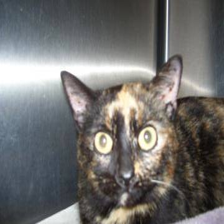


Predicted Class: CATS
Confidence Score: 100.00%
------------------------------

--- Predicting: data/test/dogs/dog.12371.jpg ---


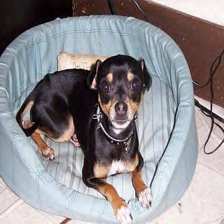


Predicted Class: DOGS
Confidence Score: 100.00%
------------------------------



In [42]:
from PIL import Image
from IPython.display import display # 如果 'display' 也顯示未定義，請一併加入
# 預測第一張圖 (貓)
predict_image(IMAGE_PATH_CAT, model, preprocess_transform, CLASS_NAMES, device)

# 預測第二張圖 (狗)
predict_image(IMAGE_PATH_DOG, model, preprocess_transform, CLASS_NAMES, device)